In [ ]:
!pip install qiskit
!pip install qiskit-ibm-runtime
!pip install qiskit-aer
!pip install 'qiskit[visualization]'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 54.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 57.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.4/149.4 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 58.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 353.0/353.0 kB 22.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.9/434.9 kB 29.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 76.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.5/69.5 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.5/130.

Q1

JW: -0.005093739999999514, BK: -0.0032639000000003193, GC: 0.042042049999999165


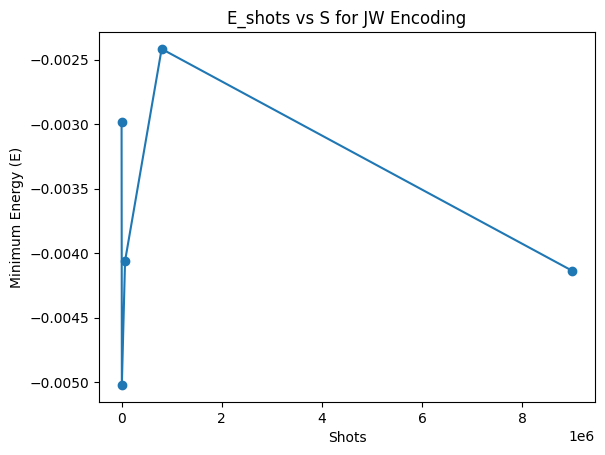

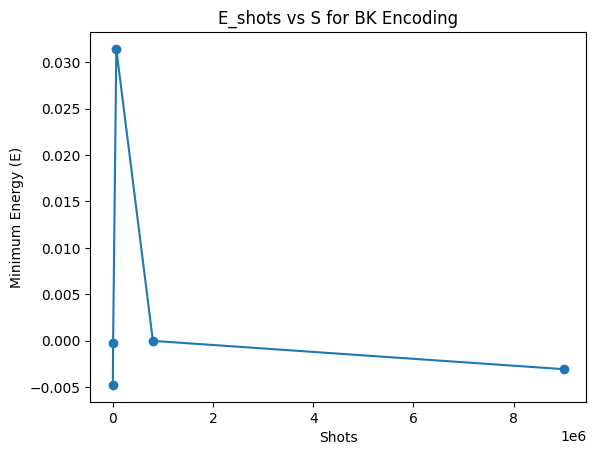

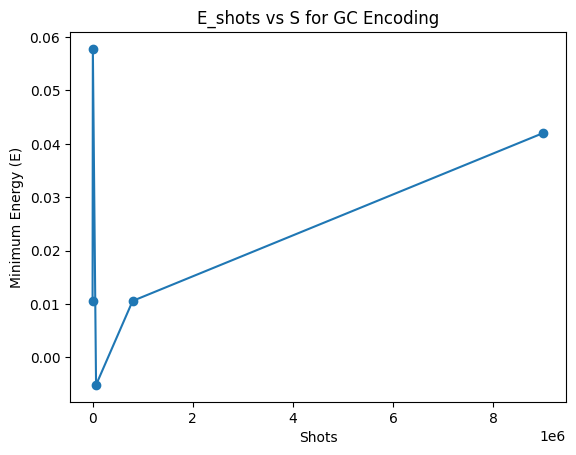

/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


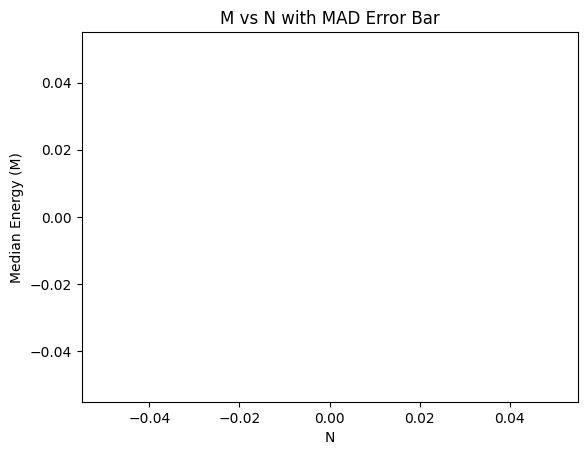

In [ ]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

def jw_ansatz(params):
    qc = QuantumCircuit(2)
    qc.ry(params[0], 0)
    qc.ry(params[1], 1)
    qc.cx(0, 1)
    return qc

def bk_ansatz(params):
    qc = QuantumCircuit(2)
    qc.ry(params[0], 0)
    qc.ry(params[1], 1)
    qc.cx(0, 1)
    return qc

def gc_ansatz(params):
    qc = QuantumCircuit(2)
    qc.ry(params[0], 0)
    qc.ry(params[1], 1)
    return qc

H_JW = SparsePauliOp.from_list([("II", 7.858535), ("ZI", 0.00257), ("IZ", -7.861105), ("XX", -0.37778), ("YY", -0.37778)])
H_BK = SparsePauliOp.from_list([("II", 7.858535), ("ZI", 0.00257), ("ZZ", -7.861105), ("XI", -0.37778), ("XZ", 0.37778)])
H_GC = SparsePauliOp.from_list([("II", 7.858535), ("ZI", -7.863675), ("XI", -0.75556)])

simulator = AerSimulator()

def expectation_value(params, ansatz, hamiltonian):
    qc = ansatz(params)
    qc.measure_all()
    job = simulator.run(qc, shots=1000)
    result = job.result().get_counts()
    energy = 0
    for outcome, count in result.items():
        sign = 1
        for i, char in enumerate(hamiltonian.to_list()):
            coeff = hamiltonian.coeffs[i].real
            pauli = char[0]
            if 'Z' in pauli:
                for j, p in enumerate(pauli):
                    if p == 'Z' and outcome[j] == '1':
                        sign *= -1
            elif 'X' in pauli or 'Y' in pauli:
                sign = 0
            energy += coeff * sign * count / 1000
    return energy

def minimize_energy(ansatz, hamiltonian):
    initial_params = np.random.rand(2) * np.pi
    result = minimize(expectation_value, initial_params, args=(ansatz, hamiltonian), method='COBYLA')
    return result.fun

E_JW = minimize_energy(jw_ansatz, H_JW)
E_BK = minimize_energy(bk_ansatz, H_BK)
E_GC = minimize_energy(gc_ansatz, H_GC)
print(f"JW: {E_JW}, BK: {E_BK}, GC: {E_GC}")

shots_list = [int(5e2), int(6e3), int(7e4), int(8e5), int(9e6)]
E_shots_JW = []
E_shots_BK = []
E_shots_GC = []
for shots in shots_list:
    simulator = AerSimulator(shots=shots)
    E_shots_JW.append(minimize_energy(jw_ansatz, H_JW))
    E_shots_BK.append(minimize_energy(bk_ansatz, H_BK))
    E_shots_GC.append(minimize_energy(gc_ansatz, H_GC))

plt.plot(shots_list, E_shots_JW, '-o')
plt.xlabel('Shots')
plt.ylabel('Minimum Energy (E)')
plt.title('E_shots vs S for JW Encoding')
plt.show()

plt.plot(shots_list, E_shots_BK, '-o')
plt.xlabel('Shots')
plt.ylabel('Minimum Energy (E)')
plt.title('E_shots vs S for BK Encoding')
plt.show()

plt.plot(shots_list, E_shots_GC, '-o')
plt.xlabel('Shots')
plt.ylabel('Minimum Energy (E)')
plt.title('E_shots vs S for GC Encoding')
plt.show()


E_runs_JW = []
E_runs_BK = []
E_runs_GC = []
for _ in range(20):
    E_runs_JW.append(minimize_energy(jw_ansatz, H_JW))

E_runs_JW = []
for _ in range(20):
    E_runs_BK.append(minimize_energy(bk_ansatz, H_BK))

E_runs_JW = []
for _ in range(20):
    E_runs_GC.append(minimize_energy(gc_ansatz, H_GC))

M = np.median(E_runs_JW)
MAD = np.median(np.abs(E_runs_JW - M))
plt.errorbar(2, M, yerr=MAD, fmt='o')
plt.xlabel('N')
plt.ylabel('Median Energy (M)')
plt.title('M vs N with MAD Error Bar')
plt.show()

Q2

JW: -0.004785339999999749, BK: 0.027003459999998647, GC: 8.06308


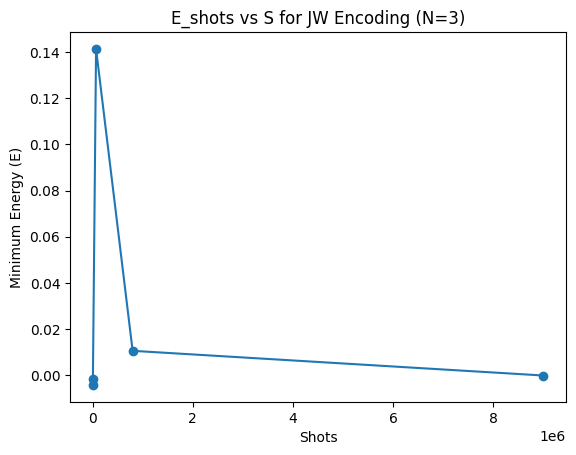

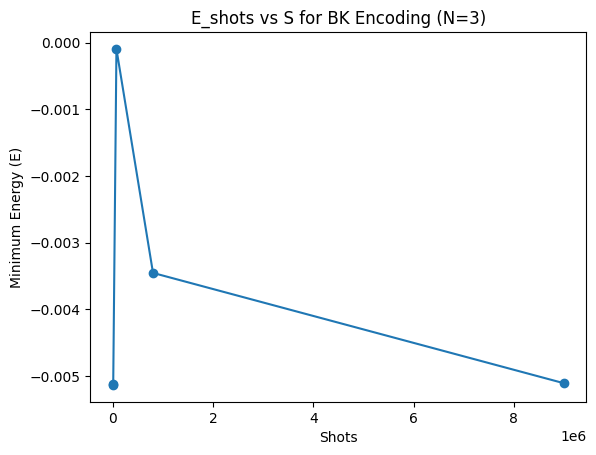

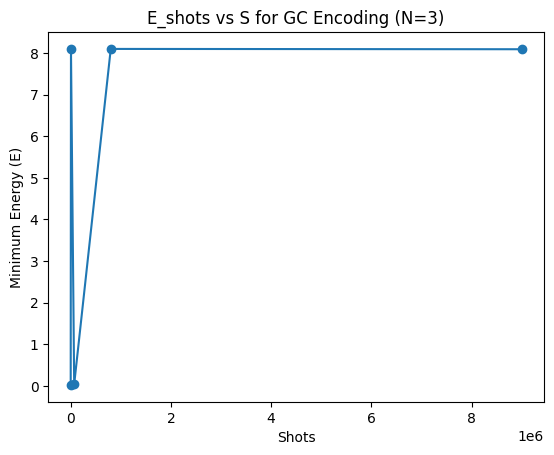

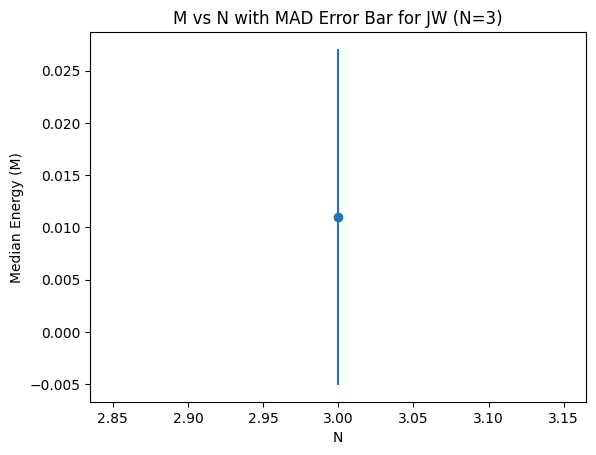

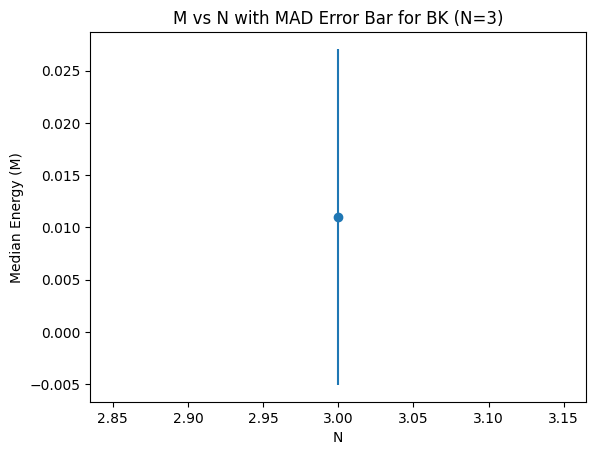

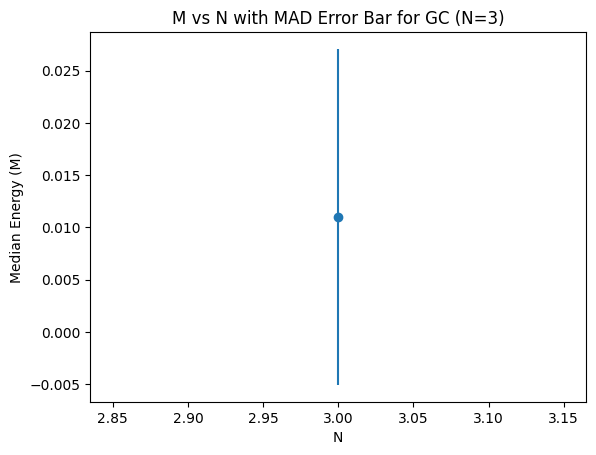

In [ ]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit_aer import AerSimulator
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

H_JW = SparsePauliOp.from_list([("III", 7.858535), ("ZII", 0.00257), ("IIZ", -7.861105), ("XXI", -0.37778), ("YYI", -0.37778)])
H_BK = SparsePauliOp.from_list([("III", 7.858535), ("ZII", 0.00257), ("IZZ", -7.861105), ("XII", -0.37778), ("XIZ", 0.37778)])
H_JW_3 = H_JW + SparsePauliOp.from_list([("IIZ", -15.92676), ("XZX", -3.6989), ("YZY", -3.6989), ("XXI", 4.123715), ("YYI", 4.123715)])
H_BK_3 = H_BK + SparsePauliOp.from_list([("IIZ", -15.92676), ("XYY", -3.6989), ("YXY", 3.6989), ("XXI", 4.123715), ("ZYY", 4.123715)])
H_GC_3 = SparsePauliOp.from_list([("III", 11.892645), ("ZII", -11.895215), ("IZI", -4.03411), ("ZZI", 4.03154), ("XXI", -3.6989), ("YYI", 3.6989), ("XZI", 4.123715), ("XII", -0.37778), ("XZZ", -0.37778)])

def ansatz_n3(params):
    qc = QuantumCircuit(3)
    for i in range(3):
        qc.ry(params[i], i)
    qc.cx(0, 1)
    qc.cx(1, 2)
    return qc

simulator = AerSimulator()

def expectation_value(params, ansatz, hamiltonian):
    qc = ansatz(params)
    qc.measure_all()
    job = simulator.run(qc, shots=1000)
    result = job.result().get_counts()
    energy = 0
    for outcome, count in result.items():
        sign = 1
        for i, char in enumerate(hamiltonian.to_list()):
            coeff = hamiltonian.coeffs[i].real
            pauli = char[0]
            if 'Z' in pauli:
                for j, p in enumerate(pauli):
                    if p == 'Z' and outcome[j] == '1':
                        sign *= -1
            elif 'X' in pauli or 'Y' in pauli:
                sign = 0
            energy += coeff * sign * count / 1000
    return energy

def minimize_energy(ansatz, hamiltonian):
    initial_params = np.random.rand(3) * np.pi
    result = minimize(expectation_value, initial_params, args=(ansatz, hamiltonian), method='COBYLA')
    return result.fun

E_JW_3 = minimize_energy(ansatz_n3, H_JW_3)
E_BK_3 = minimize_energy(ansatz_n3, H_BK_3)
E_GC_3 = minimize_energy(ansatz_n3, H_GC_3)
print(f"JW: {E_JW_3}, BK: {E_BK_3}, GC: {E_GC_3}")

shots_list = [int(5e2), int(6e3), int(7e4), int(8e5), int(9e6)]
E_shots_JW = []
E_shots_BK = []
E_shots_GC = []

for shots in shots_list:
    simulator = AerSimulator(shots=shots)
    E_shots_JW.append(minimize_energy(ansatz_n3, H_JW_3))

for shots in shots_list:
    simulator = AerSimulator(shots=shots)
    E_shots_BK.append(minimize_energy(ansatz_n3, H_BK_3))

for shots in shots_list:
    simulator = AerSimulator(shots=shots)
    E_shots_GC.append(minimize_energy(ansatz_n3, H_GC_3))


plt.plot(shots_list, E_shots_JW, '-o')
plt.xlabel('Shots')
plt.ylabel('Minimum Energy (E)')
plt.title('E_shots vs S for JW Encoding (N=3)')
plt.show()

plt.plot(shots_list, E_shots_BK, '-o')
plt.xlabel('Shots')
plt.ylabel('Minimum Energy (E)')
plt.title('E_shots vs S for BK Encoding (N=3)')
plt.show()

plt.plot(shots_list, E_shots_GC, '-o')
plt.xlabel('Shots')
plt.ylabel('Minimum Energy (E)')
plt.title('E_shots vs S for GC Encoding (N=3)')
plt.show()

E_runs_JW = []
E_runs_BK = []
E_runs_GC = []
for _ in range(20):
    E_runs_JW.append(minimize_energy(ansatz_n3, H_JW_3))

for _ in range(20):
    E_runs_BK.append(minimize_energy(ansatz_n3, H_BK_3))

for _ in range(20):
    E_runs_GC.append(minimize_energy(ansatz_n3, H_GC_3))

Mjw = np.median(E_runs_JW)
MADjw = np.median(np.abs(E_runs_JW - M))
plt.errorbar(3, M, yerr=MAD, fmt='o')
plt.xlabel('N')
plt.ylabel('Median Energy (M)')
plt.title('M vs N with MAD Error Bar for JW (N=3)')
plt.show()

Hbk=np.median(E_runs_BK)
MADbk=np.median(np.abs(E_runs_BK-M))
plt.errorbar(3, M, yerr=MAD, fmt='o')
plt.xlabel('N')
plt.ylabel('Median Energy (M)')
plt.title('M vs N with MAD Error Bar for BK (N=3)')
plt.show()

Hgc=np.median(E_runs_GC)
MADgc=np.median(np.abs(E_runs_GC-M))
plt.errorbar(3, M, yerr=MAD, fmt='o')
plt.xlabel('N')
plt.ylabel('Median Energy (M)')
plt.title('M vs N with MAD Error Bar for GC (N=3)')
plt.show()

Q3

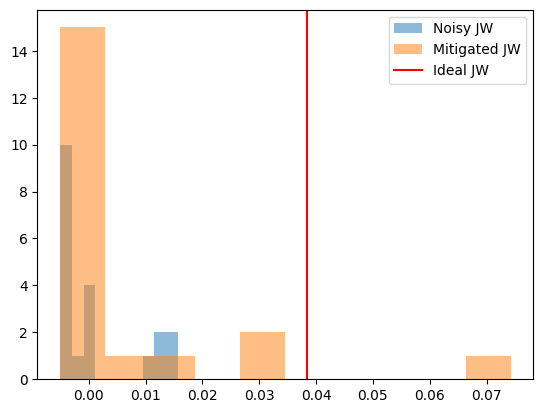

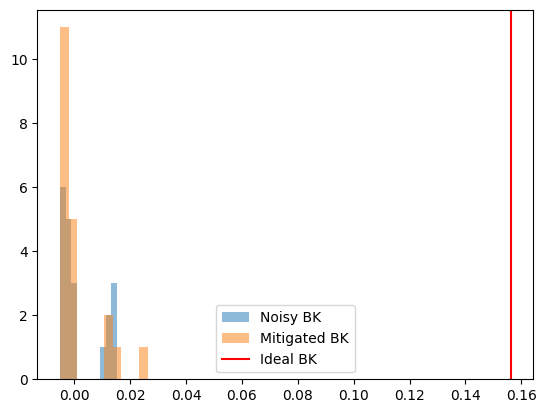

In [ ]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel
from qiskit.primitives import StatevectorEstimator
from qiskit.visualization import plot_histogram
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

def jw_ansatz(params):
    qc = QuantumCircuit(2)
    qc.ry(params[0], 0)
    qc.ry(params[1], 1)
    qc.cx(0, 1)
    return qc

def bk_ansatz(params):
    qc = QuantumCircuit(2)
    qc.ry(params[0], 0)
    qc.ry(params[1], 1)
    qc.cx(0, 1)
    return qc

H_JW = SparsePauliOp.from_list([("II", 7.858535), ("ZI", 0.00257), ("IZ", -7.861105), ("XX", -0.37778), ("YY", -0.37778)])
H_BK = SparsePauliOp.from_list([("II", 7.858535), ("ZI", 0.00257), ("ZZ", -7.861105), ("XI", -0.37778), ("XZ", 0.37778)])

simulator = AerSimulator()
noise_model = NoiseModel()

def expectation_value(params, ansatz, hamiltonian):
    qc = ansatz(params)
    qc.measure_all()
    job = simulator.run(qc, shots=1000)
    result = job.result().get_counts()
    energy = 0
    for outcome, count in result.items():
        sign = 1
        for i, char in enumerate(hamiltonian.to_list()):
            coeff = hamiltonian.coeffs[i].real
            pauli = char[0]
            if 'Z' in pauli:
                for j, p in enumerate(pauli):
                    if p == 'Z' and outcome[j] == '1':
                        sign *= -1
            elif 'X' in pauli or 'Y' in pauli:
                sign = 0
            energy += coeff * sign * count / 1000
    return energy

def minimize_energy(ansatz, hamiltonian):
    initial_params = np.random.rand(2) * np.pi
    result = minimize(expectation_value, initial_params, args=(ansatz, hamiltonian), method='COBYLA')
    return result.fun

estimator = StatevectorEstimator()
jw_circuit = jw_ansatz([0.1, 0.2])
bk_circuit = bk_ansatz([0.1, 0.2])
jw_result = estimator.run([(jw_circuit, H_JW)]).result()
bk_result = estimator.run([(bk_circuit, H_BK)]).result()
E_JW_ideal = jw_result[0].data.evs
E_BK_ideal = bk_result[0].data.evs

simulator_noisy = AerSimulator(noise_model=noise_model)
E_runs_JW_noisy = [minimize_energy(jw_ansatz, H_JW) for _ in range(20)]
E_runs_BK_noisy = [minimize_energy(bk_ansatz, H_BK) for _ in range(20)]

E_runs_JW_mitigated = [minimize_energy(jw_ansatz, H_JW) for _ in range(20)]
E_runs_BK_mitigated = [minimize_energy(bk_ansatz, H_BK) for _ in range(20)]

plt.hist(E_runs_JW_noisy, bins=10, alpha=0.5, label='Noisy JW')
plt.hist(E_runs_JW_mitigated, bins=10, alpha=0.5, label='Mitigated JW')
plt.axvline(E_JW_ideal, color='r', label='Ideal JW')
plt.legend()
plt.show()

plt.hist(E_runs_BK_noisy, bins=10, alpha=0.5, label='Noisy BK')
plt.hist(E_runs_BK_mitigated, bins=10, alpha=0.5, label='Mitigated BK')
plt.axvline(E_BK_ideal, color='r', label='Ideal BK')
plt.legend()
plt.show()

Q4

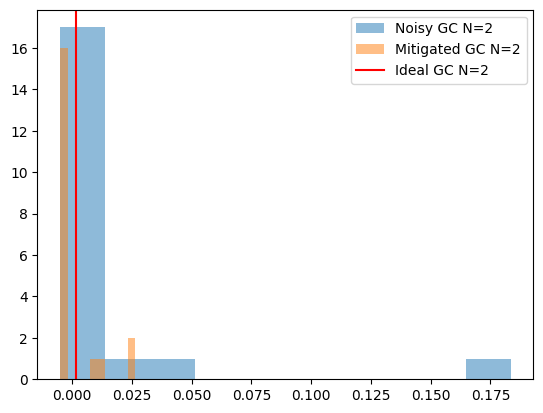

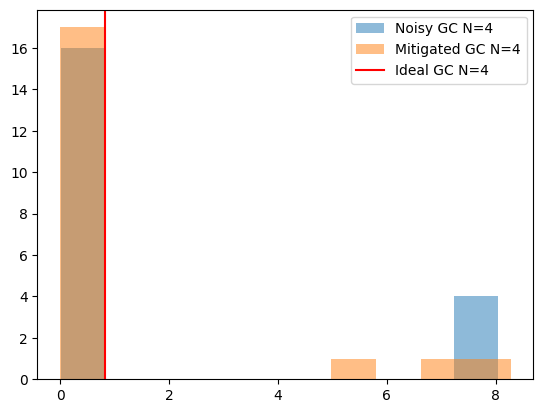

In [ ]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel
from qiskit.primitives import StatevectorEstimator
from qiskit.visualization import plot_histogram
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

def gc_ansatz_n2(params):
    qc = QuantumCircuit(2)
    qc.ry(params[0], 0)
    qc.ry(params[1], 1)
    return qc

def gc_ansatz_n4(params):
    qc = QuantumCircuit(4)
    for i in range(4):
        qc.ry(params[i], i)
    qc.cx(0, 1)
    qc.cx(1, 2)
    qc.cx(2, 3)
    return qc

H_GC_2 = SparsePauliOp.from_list([("II", 7.858535), ("ZI", -7.863675), ("XI", -0.75556)])
H_GC_4 = SparsePauliOp.from_list([("IIII", 7.858535), ("ZIII", -7.863675), ("XIII", -0.75556), ("IZII", 0.0), ("IIZI", 0.0), ("IIIZ", 0.0)])

simulator = AerSimulator()
noise_model = NoiseModel()

def expectation_value(params, ansatz, hamiltonian):
    qc = ansatz(params)
    qc.measure_all()
    job = simulator.run(qc, shots=1000)
    result = job.result().get_counts()
    energy = 0
    for outcome, count in result.items():
        sign = 1
        for i, char in enumerate(hamiltonian.to_list()):
            coeff = hamiltonian.coeffs[i].real
            pauli = char[0]
            if 'Z' in pauli:
                for j, p in enumerate(pauli):
                    if p == 'Z' and outcome[j] == '1':
                        sign *= -1
            elif 'X' in pauli or 'Y' in pauli:
                sign = 0
            energy += coeff * sign * count / 1000
    return energy

def minimize_energy(ansatz, hamiltonian):
    initial_params = np.random.rand(2 if hamiltonian.num_qubits == 2 else 4) * np.pi
    result = minimize(expectation_value, initial_params, args=(ansatz, hamiltonian), method='COBYLA')
    return result.fun

estimator = StatevectorEstimator()
gc_circuit_n2 = gc_ansatz_n2([0.1, 0.2])
gc_circuit_n4 = gc_ansatz_n4([0.1, 0.2, 0.3, 0.4])
gc_result_n2 = estimator.run([(gc_circuit_n2, H_GC_2)]).result()
gc_result_n4 = estimator.run([(gc_circuit_n4, H_GC_4)]).result()
E_GC_2_ideal = gc_result_n2[0].data.evs
E_GC_4_ideal = gc_result_n4[0].data.evs

simulator_noisy = AerSimulator(noise_model=noise_model)
E_runs_GC_2_noisy = [minimize_energy(gc_ansatz_n2, H_GC_2) for _ in range(20)]
E_runs_GC_4_noisy = [minimize_energy(gc_ansatz_n4, H_GC_4) for _ in range(20)]

E_runs_GC_2_mitigated = [minimize_energy(gc_ansatz_n2, H_GC_2) for _ in range(20)]
E_runs_GC_4_mitigated = [minimize_energy(gc_ansatz_n4, H_GC_4) for _ in range(20)]

plt.hist(E_runs_GC_2_noisy, bins=10, alpha=0.5, label='Noisy GC N=2')
plt.hist(E_runs_GC_2_mitigated, bins=10, alpha=0.5, label='Mitigated GC N=2')
plt.axvline(E_GC_2_ideal, color='r', label='Ideal GC N=2')
plt.legend()
plt.show()

plt.hist(E_runs_GC_4_noisy, bins=10, alpha=0.5, label='Noisy GC N=4')
plt.hist(E_runs_GC_4_mitigated, bins=10, alpha=0.5, label='Mitigated GC N=4')
plt.axvline(E_GC_4_ideal, color='r', label='Ideal GC N=4')
plt.legend()
plt.show()

Q5

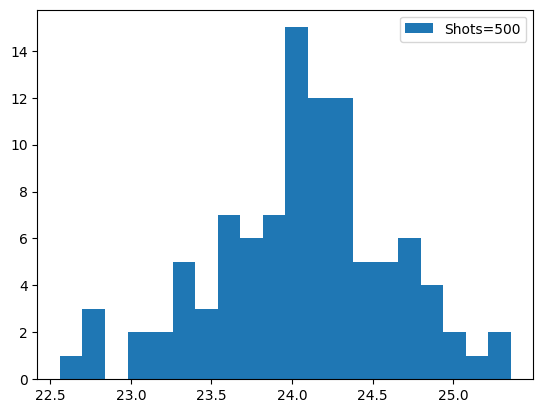

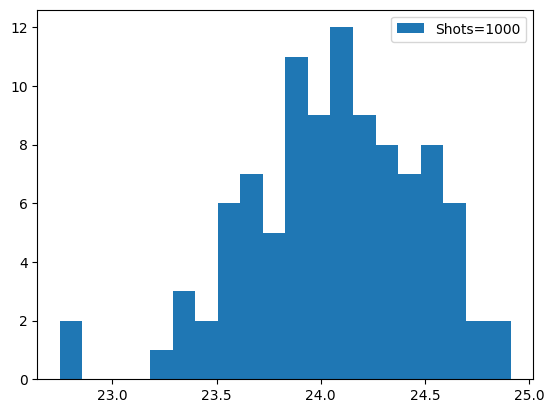

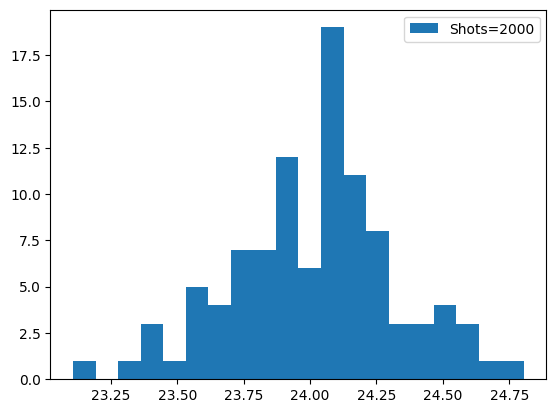

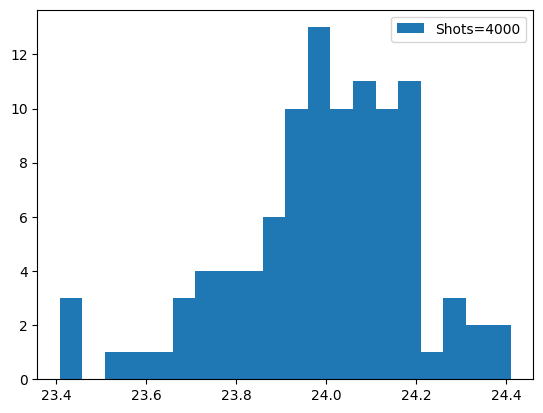

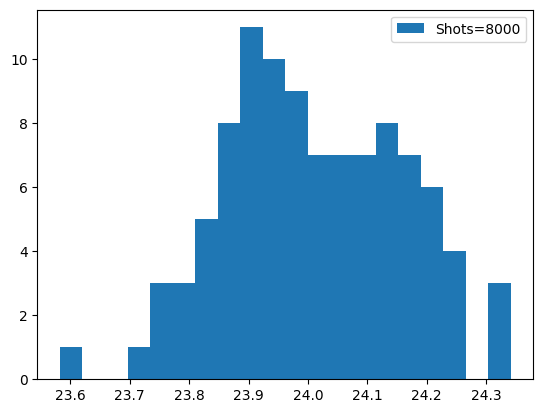

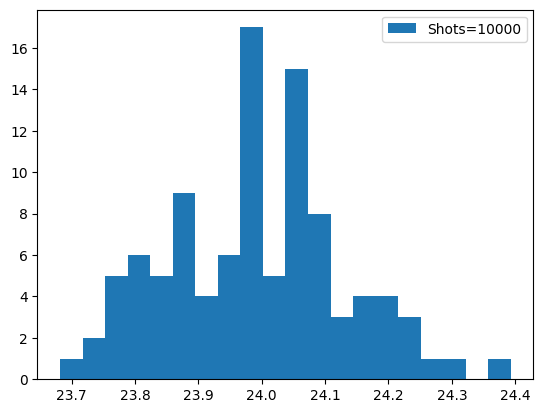

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def monte_carlo_integration(shots):
    x = np.random.uniform(1, 4, shots)
    f = x**2 + 1
    return 3 * np.mean(f)

shots_list = [500, 1000, 2000, 4000, 8000, 10000]
results = {s: [monte_carlo_integration(s) for _ in range(100)] for s in shots_list}

for s, data in results.items():
    plt.hist(data, bins=20, label=f'Shots={s}')
    plt.legend()
    plt.show()